In [2]:
from os import path
import requests
from requests.auth import HTTPBasicAuth
import pandas as pd

import numpy as np

from datetime import datetime, timezone
from dateutil import tz
import pytz

import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model as lm

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

In [5]:
com = pd.read_csv("alameda-county-2018-amy-aggregate-comstock.csv")
# res["Timestamp (PST)"] = pd.DatetimeIndex(res['Timestamp (EST)']).tz_convert("America/Los_Angeles")
com.insert(0, "date", pd.DatetimeIndex(com['Timestamp (EST)']).tz_convert("America/Los_Angeles"))
com.insert(1, "year", [t.year for t in com["date"]])
# res.insert(2, "month", [t.month for t in res["date"]])
# res.insert(3, "day", [t.day for t in res["date"]])
# res.insert(4, "hour", [t.hour for t in res["date"]])
# res.insert(1, "date", [t.date for t in res["Timestamp (PST)"]])
com = com.drop(columns="Timestamp (EST)")
com = com[com["year"] == 2018]
com

,date,year,baseline.out.district_cooling.cooling.energy_consumption.kwh,baseline.out.district_heating.heating.energy_consumption.kwh,baseline.out.district_heating.water_systems.energy_consumption.kwh,baseline.out.electricity.cooling.energy_consumption.kwh,baseline.out.electricity.exterior_lighting.energy_consumption.kwh,baseline.out.electricity.fans.energy_consumption.kwh,baseline.out.electricity.heat_recovery.energy_consumption.kwh,baseline.out.electricity.heat_rejection.energy_consumption.kwh,...,baseline.out.natural_gas.water_systems.energy_consumption.kwh,baseline.out.district_cooling.total.energy_consumption.kwh,baseline.out.district_heating.total.energy_consumption.kwh,baseline.out.electricity.total.energy_consumption.kwh,baseline.out.natural_gas.total.energy_consumption.kwh,baseline.out.other_fuel.heating.energy_consumption.kwh,baseline.out.other_fuel.water_systems.energy_consumption.kwh,baseline.out.other_fuel.total.energy_consumption.kwh,baseline.out.site_energy.total.energy_consumption.kwh,baseline.upgrade.kwh
11,2018-01-01 00:00:00-08:00,2018,463.796731,262.946850,0.000000,2077.811689,9354.853552,30980.984331,0.0,1.826374,...,2746.320866,463.796731,262.946850,99240.703864,63703.998199,157.774547,73.306496,231.081043,163902.528138,0
12,2018-01-01 00:15:00-08:00,2018,450.708128,245.762816,0.000000,2112.110922,9101.962665,30851.927594,0.0,8.981971,...,2265.341650,450.708128,245.762816,98880.587504,60263.778034,167.003507,65.056571,232.060078,160072.898007,0
13,2018-01-01 00:30:00-08:00,2018,445.857188,253.874522,0.000000,2064.144739,9101.962665,30864.554899,0.0,8.596916,...,2365.700069,445.857188,253.874522,98939.921717,58266.707505,172.480615,60.198936,232.679552,158139.041930,0
14,2018-01-01 00:45:00-08:00,2018,442.614650,261.116936,0.000000,2011.405147,9101.962665,30882.720300,0.0,8.388877,...,2307.500577,442.614650,261.116936,99184.089168,58439.063552,177.955824,51.226996,229.182820,158556.068575,0
15,2018-01-01 01:00:00-08:00,2018,440.758909,267.462564,0.000000,1967.425808,9101.962665,30898.313255,0.0,7.863418,...,2320.683768,440.758909,267.462564,99005.586173,59241.852072,181.959726,28.616445,210.576171,159166.237335,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35035,2018-12-31 20:00:00-08:00,2018,593.421302,120.406369,0.000000,2875.400966,9354.853552,31379.832852,0.0,8.449734,...,4287.663621,593.421302,120.406369,114217.893691,62283.763321,80.472080,169.565683,250.037763,177465.524115,0
35036,2018-12-31 20:15:00-08:00,2018,583.169823,127.574761,0.000000,2772.369435,9354.853552,31368.144436,0.0,8.470626,...,4175.805879,583.169823,127.574761,112776.531508,60524.119857,86.455080,168.950805,255.405885,174266.803483,0
35037,2018-12-31 20:30:00-08:00,2018,572.022584,134.311925,0.000000,2674.520462,9354.853552,31363.115484,0.0,8.493289,...,3952.101564,572.022584,134.311925,111479.723290,59156.508437,91.996830,165.203929,257.200759,171599.768624,0
35038,2018-12-31 20:45:00-08:00,2018,554.772195,141.174881,0.250197,2574.292311,9354.853552,31346.138851,0.0,8.193746,...,3890.001200,554.772195,141.425078,110084.457696,59489.514761,97.633219,146.599641,244.232860,170514.404200,0


In [6]:
com_electricity = com[[col for col in res.columns if "baseline.out.electricity" in col]]
com_electricity = com_electricity.rename(columns=dict(zip(com_electricity.columns, [c[25:-23] for c in com_electricity.columns])))
com_electricity["date"] = com["date"]

In [7]:
all_data = pd.read_csv("wattime_data.csv")
df = all_data
df["date"] = [datetime.fromisoformat(s[:-1]) for s in df["point_time"]]
df["date"] = [timestamp.tz_localize("America/Los_Angeles", ambiguous=0, nonexistent="shift_forward") for timestamp in df["date"]]
df["time"] = pd.DatetimeIndex(df['date']).time
df["year"] = [d.year for d in df["date"]]
df["month"] = [d.month for d in df["date"]]
df["day_of_month"] = pd.DatetimeIndex(df['date']).day
df["day_of_week"] = [datetime.weekday(d) for d in df["date"]]
df["day_of_week"] = df["day_of_week"].replace({0 : "Mon", 1 : "Tue", 2 : "Wed", 3 : "Thurs", 4 : "Fri", 5 : "Sat", 6 : "Sun"})
df["hour"] = [d.hour for d in df["time"]]
df["minute"] = [d.minute for d in df["time"]]
df = df.rename(columns = {"value" : "MOER"})
df = df.drop("point_time", axis=1)
data18 = df[df['year'] == 2018]
data18 = data18.sort_values("date")
data18 = data18[data18["minute"] % 15 == 0]
data18 = data18.drop(["frequency", "market", "ba", "datatype", "version"], axis= 1)
data18 = data18.drop_duplicates()
data18

,Unnamed: 0,MOER,date,time,year,month,day_of_month,day_of_week,hour,minute
0,96,1022.0,2018-01-01 00:00:00-08:00,00:00:00,2018,1,1,Mon,0,0
3,93,1021.0,2018-01-01 00:15:00-08:00,00:15:00,2018,1,1,Mon,0,15
6,90,1018.0,2018-01-01 00:30:00-08:00,00:30:00,2018,1,1,Mon,0,30
9,87,1006.0,2018-01-01 00:45:00-08:00,00:45:00,2018,1,1,Mon,0,45
12,84,1007.0,2018-01-01 01:00:00-08:00,01:00:00,2018,1,1,Mon,1,0
...,...,...,...,...,...,...,...,...,...,...
105117,111,982.0,2018-12-31 22:45:00-08:00,22:45:00,2018,12,31,Mon,22,45
105120,108,1025.0,2018-12-31 23:00:00-08:00,23:00:00,2018,12,31,Mon,23,0
105123,105,1017.0,2018-12-31 23:15:00-08:00,23:15:00,2018,12,31,Mon,23,15
105126,102,1028.0,2018-12-31 23:30:00-08:00,23:30:00,2018,12,31,Mon,23,30


In [8]:
all18 = data18.merge(com_electricity, on= "date")
all18 = all18.drop(['Unnamed: 0'], axis= 1)
# all18 = all18.sort_values(by=['MOER'], ascending= False)
all18

,MOER,date,time,year,month,day_of_month,day_of_week,hour,minute,cooling,...,fans,heat_recovery,heat_rejection,heating,interior_equipment,interior_lighting,pumps,refrigeration,water_systems,total
0,1022.0,2018-01-01 00:00:00-08:00,00:00:00,2018,1,1,Mon,0,0,2077.811689,...,30980.984331,0.0,1.826374,12662.375044,28748.532117,12603.633190,789.790064,462.495411,1558.402093,99240.703864
1,1021.0,2018-01-01 00:15:00-08:00,00:15:00,2018,1,1,Mon,0,15,2112.110922,...,30851.927594,0.0,8.981971,13195.010570,28907.964671,12496.965596,787.348263,286.428492,1131.886760,98880.587504
2,1018.0,2018-01-01 00:30:00-08:00,00:30:00,2018,1,1,Mon,0,30,2064.144739,...,30864.554899,0.0,8.596916,13377.602168,28724.024427,12421.619641,787.407013,287.410774,1302.598475,98939.921717
3,1006.0,2018-01-01 00:45:00-08:00,00:45:00,2018,1,1,Mon,0,45,2011.405147,...,30882.720300,0.0,8.388877,13567.526445,28807.351154,12330.534022,787.479868,287.528644,1399.192047,99184.089168
4,1007.0,2018-01-01 01:00:00-08:00,01:00:00,2018,1,1,Mon,1,0,1967.425808,...,30898.313255,0.0,7.863418,13737.156659,28588.813374,12242.598620,787.283483,287.565901,1386.602990,99005.586173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35044,984.0,2018-12-31 20:00:00-08:00,20:00:00,2018,12,31,Mon,20,0,2875.400966,...,31379.832852,0.0,8.449734,7521.927815,39824.940317,19305.695547,801.734577,487.502839,2657.555492,114217.893691
35045,968.0,2018-12-31 20:15:00-08:00,20:15:00,2018,12,31,Mon,20,15,2772.369435,...,31368.144436,0.0,8.470626,7802.779811,39034.051388,18563.069750,800.228342,487.476919,2585.087249,112776.531508
35046,961.0,2018-12-31 20:30:00-08:00,20:30:00,2018,12,31,Mon,20,30,2674.520462,...,31363.115484,0.0,8.493289,8051.794547,38390.252263,17859.752236,797.831084,487.467970,2491.642403,111479.723290
35047,960.0,2018-12-31 20:45:00-08:00,20:45:00,2018,12,31,Mon,20,45,2574.292311,...,31346.138851,0.0,8.193746,8312.476166,37625.417604,17217.977305,796.024100,487.313945,2361.770117,110084.457696


In [9]:
def get_extreme_peaks_by_percentile(percentile, waking_hours_only=False, rolling=True):  
    """
    Returns all extreme peaks where the peak MOER is in the specified percentile of all MOER data
    
    percentile - int in [0, 100] that determines the threshold for an extreme peak
    waking_hours_only - allows for the option to exclude peaks in the early morning hours and only consider 
        peaks between 8am and midnight
    """
    if waking_hours_only:
        data = all18[~all18["hour"].isin([0, 1, 2, 3, 4, 5, 6, 7])]
    else:
        data = all18
    
    data = data.reset_index(drop=True)
    
    moers = data["MOER"]

    cutoff = np.percentile(moers, percentile)
    peak_indices = []
    for i in range(1, len(moers)):
        if moers[i] >= cutoff and moers[i-1] < moers[i] and moers[i+1] < moers[i]:
            peak_indices.append(i)
    
    return data.iloc[peak_indices]

In [10]:
def get_extreme_peaks_by_value(cutoff, waking_hours_only=False):  
    """
    Returns all extreme peaks where the peak MOER is in the specified cutoff of all MOER data
    
    cutoff - MOER cutoff that determines the threshold for an extreme peak
    waking_hours_only - allows for the option to exclude peaks in the early morning hours and only consider 
        peaks between 8am and midnight
    """
    if waking_hours_only:
        data = all18[~all18["hour"].isin([0, 1, 2, 3, 4, 5, 6, 7])]
    else:
        data = all18
    
    data = data.reset_index(drop=True)
    
    moers = data["MOER"]
    
    peak_indices = []
    for i in range(1, len(moers)):
        if moers[i] >= cutoff and moers[i-1] < moers[i] and moers[i+1] < moers[i]:
            peak_indices.append(i)
            
    return data.iloc[peak_indices]

In [11]:
def get_top_n_peaks(n, waking_hours_only=False):  
    """
    Returns all extreme peaks where the peak MOER is in the specified cutoff of all MOER data
    
    n - number of peaks to return
    waking_hours_only - allows for the option to exclude peaks in the early morning hours and only consider 
        peaks between 8am and midnight
    """
    return get_extreme_peaks_by_percentile(99, waking_hours_only).sort_values(by=["MOER"], ascending=False).head(n)

In [12]:
df = all18
top_100_peaks = get_top_n_peaks(100, waking_hours_only=True)

<AxesSubplot:xlabel='date', ylabel='MOER'>

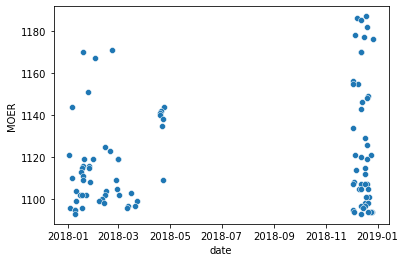

In [13]:
sns.scatterplot(data=top_100_peaks, x="date", y="MOER")

<AxesSubplot:xlabel='hour', ylabel='MOER'>

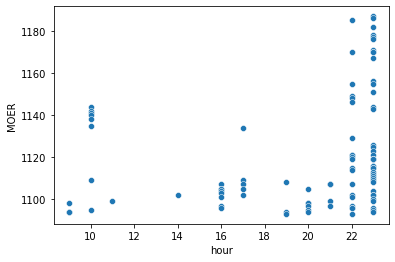

In [14]:
sns.scatterplot(data=top_100_peaks, x="hour", y="MOER")

In [15]:
all18.columns

Index(['MOER', 'date', 'time', 'year', 'month', 'day_of_month', 'day_of_week',
       'hour', 'minute', 'cooling', 'exterior_lighting', 'fans',
       'heat_recovery', 'heat_rejection', 'heating', 'interior_equipment',
       'interior_lighting', 'pumps', 'refrigeration', 'water_systems',
       'total'],
      dtype='object')

In [16]:
def get_pie(timestamp):
    df = all18.loc[all18["date"] == timestamp]
    print("Timestamp: " + timestamp)
    print("MOER: " + str(df["MOER"]))
    df = df.drop(columns=["MOER", "date", "time", "year", "month", "day_of_month", "day_of_week", "hour", "minute", "total"])
    to_plot = pd.DataFrame({"MOER": df.values[0], "color" : sns.color_palette() + sns.color_palette() + sns.color_palette()[:3], "Appliance" : df.columns})
    to_plot = to_plot.sort_values(by="MOER")
    plt.pie(to_plot["MOER"], labels = to_plot["Appliance"], colors = to_plot["color"], autopct='%.0f%%')

In [17]:
sns.set(rc={'figure.figsize':(20,8.27)})
all18[all18["date"] == "2018-02-04 16:00:00-08:00"]

,MOER,date,time,year,month,day_of_month,day_of_week,hour,minute,cooling,...,fans,heat_recovery,heat_rejection,heating,interior_equipment,interior_lighting,pumps,refrigeration,water_systems,total
3330,75.0,2018-02-04 16:00:00-08:00,16:00:00,2018,2,4,Sun,16,0,22544.017678,...,32322.025569,0.0,150.84316,326.113014,32294.270606,18290.437421,888.436025,490.566854,3110.570383,110417.280709


In [18]:
top_100_peaks.sort_values("MOER", ascending=False)

,MOER,date,time,year,month,day_of_month,day_of_week,hour,minute,cooling,...,fans,heat_recovery,heat_rejection,heating,interior_equipment,interior_lighting,pumps,refrigeration,water_systems,total
22473,1187.0,2018-12-17 23:15:00-08:00,23:15:00,2018,12,17,Mon,23,15,2279.188358,...,30921.111108,0.0,13.150682,10758.603346,29897.715329,12989.812254,794.133350,462.505761,1706.037456,99177.111196
21833,1186.0,2018-12-07 23:15:00-08:00,23:15:00,2018,12,7,Fri,23,15,2105.160139,...,30879.274827,0.0,8.162302,11286.727403,29968.993590,13005.632931,789.118104,462.489942,2039.020717,99899.433505
22149,1185.0,2018-12-12 22:15:00-08:00,22:15:00,2018,12,12,Wed,22,15,2105.999001,...,31217.793674,0.0,13.305826,10247.799439,33078.123221,13949.909472,791.449623,462.507695,1868.724209,103090.465710
22539,1182.0,2018-12-18 23:45:00-08:00,23:45:00,2018,12,18,Tue,23,45,2890.221663,...,30786.558560,0.0,20.212450,8809.179100,29034.369401,12696.633095,800.001274,462.520103,1600.392511,96454.941708
21641,1178.0,2018-12-04 23:15:00-08:00,23:15:00,2018,12,4,Tue,23,15,2327.260082,...,31325.663535,0.0,12.096689,11611.326570,29968.993590,13005.632931,803.067028,462.519057,1970.357824,100841.770857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22866,1094.0,2018-12-24 09:30:00-08:00,09:30:00,2018,12,24,Mon,9,30,4330.233380,...,33564.076110,0.0,47.682016,6650.919236,59274.413860,37413.324545,826.056874,491.627572,11095.391049,153693.724642
22864,1094.0,2018-12-24 09:00:00-08:00,09:00:00,2018,12,24,Mon,9,0,5307.849955,...,33263.686111,0.0,45.073899,7456.664647,55831.206453,35399.801291,821.234430,491.169154,10395.696908,149012.382847
22652,1094.0,2018-12-20 20:00:00-08:00,20:00:00,2018,12,20,Thurs,20,0,2569.840018,...,31495.306375,0.0,27.536790,7606.573653,37451.151240,15665.829757,796.173930,491.377571,2690.328750,108148.971637
22138,1093.0,2018-12-12 19:30:00-08:00,19:30:00,2018,12,12,Wed,19,30,3557.080812,...,31407.905499,0.0,24.994457,6454.223034,41266.639774,20751.979941,809.078298,490.853566,5174.723634,119292.332567


## Average energy consumption during a top 100 peak

In [21]:
means

cooling                4169.135808
exterior_lighting      7109.688699
fans                  31683.474081
heat_recovery             0.000000
heat_rejection           35.961053
heating                8383.754521
interior_equipment    35477.415193
interior_lighting     17557.664820
pumps                   797.916498
refrigeration           475.488854
water_systems          3746.109142
dtype: float64

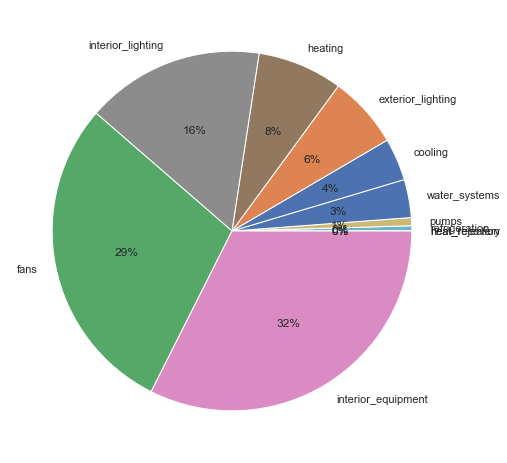

In [22]:
means = top_100_peaks.mean().drop(columns=["MOER", "date", "time", "year", "month", "day_of_month", "day_of_week", "hour", "minute", "total"])[6:-1]
to_plot = pd.DataFrame({"Appliance": means.index, "Value": means, "color" : sns.color_palette() + sns.color_palette()[:1]})
to_plot = to_plot.sort_values(by="Value")
plt.pie(to_plot["Value"], labels = to_plot.index, colors = to_plot["color"], autopct='%.0f%%');

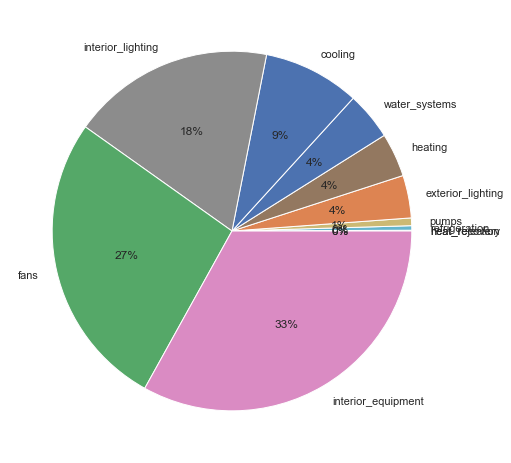

In [24]:
all_means = all18.mean().drop(columns=["MOER", "date", "time", "year", "month", "day_of_month", "day_of_week", "hour", "minute", "total"])[6:-1]
to_plot = pd.DataFrame({"Appliance": all_means.index, "Value": all_means, "color" : sns.color_palette() + sns.color_palette()[:1]})
to_plot = to_plot.sort_values(by="Value")
plt.pie(to_plot["Value"], labels = to_plot.index, colors = to_plot["color"], autopct='%.0f%%');

In [25]:
means = means.sort_values(ascending=False)

In [26]:
df = pd.DataFrame({"kWH" : means})
df2 = pd.DataFrame({"kWH" : all_means})

In [27]:
combined = pd.merge(df, df2, left_index=True, right_index=True).rename(columns={"kWH_x" : "2018 Top 100 Peak Average Load Profile", "kWH_y" : "2018 Average Load Profile"})
combined["Use"] = combined.index
combined = combined.melt(id_vars=["Use"])

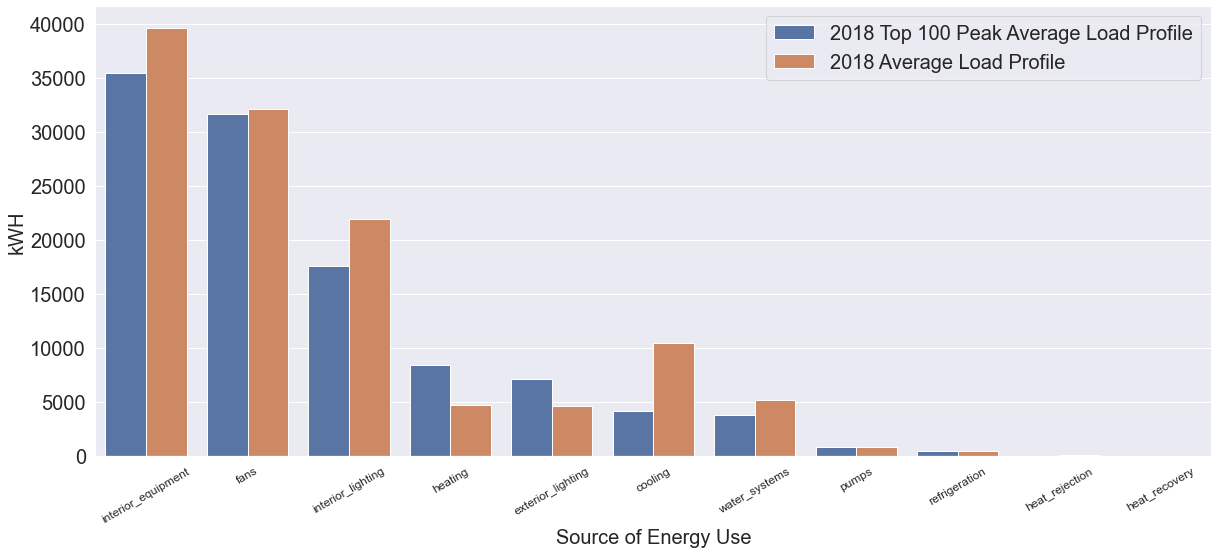

In [28]:
sns.barplot(data=combined, x="Use", y="value", hue="variable")
plt.xlabel("Source of Energy Use", fontsize=20)
plt.ylabel("kWH", fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(rotation=30, fontsize=12)
plt.legend(loc=1, prop={'size': 20});

In [29]:
sum(df["kWH"])

109436.60866833682

In [30]:
sum(df2["kWH"])

119963.76226926589